# Задание

Взять данные по [ссылке](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud) и:

- Провести разведочный анализ данных
    - какие зависимости в данных?
    - [сбалансированы](https://www.kaggle.com/code/marcinrutecki/best-techniques-and-metrics-for-imbalanced-dataset) ли классы?
    - основные статистики признаков
- Разделить данные на train/test
    - разделить на обучающую и тестовую подвыборки
    - сравнить статистики подвыборок и генеральной выборки
- Обучить модели классификации
    - какие метрики точности?
    - какая модель лучше всего справилась?

Импортирыем необходимые библиотеки:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


from sklearn.metrics import classification_report
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

sns.set()

# О наборе данных

Набор данных содержит транзакции, совершенные по кредитным картам в сентябре 2013 года европейскими держателями карт.
В этом наборе данных представлены транзакции, совершенные за два дня, где мы имеем 492 мошенничества из 284 807 транзакций. Набор данных сильно несбалансирован, положительный класс (мошенники) составляет 0,172% от всех транзакций.

Он содержит только числовые входные переменные, которые являются результатом преобразования PCA (Principal Component Analysis). К сожалению, по соображениям конфиденциальности мы не можем предоставить исходные признаки и более подробную информацию о данных. Признаки V1, V2, ... V28 - это главные компоненты, полученные с помощью PCA, единственные признаки, которые не были преобразованы с помощью PCA, - это `Time` и `Amount`.
* Признак `Time` содержит секунды, прошедшие между каждой транзакцией и первой транзакцией в наборе данных.
* Признак `Amount` - это сумма транзакции, этот признак может быть использован для обучения с учетом затрат в зависимости от примера.
* Признак `Class` является переменной отклика и принимает значение 1 в случае мошенничества и 0 в противном случае.

# Обработаем данные

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


    Пропуски в данных отсутствуют

In [5]:
nan = df.isna().sum().sum()
print(f'Количество значений NaN: {nan}')

Количество значений NaN: 0


    Удалим дубликаты из данных

In [6]:
len_df = len(df)
df.drop_duplicates(inplace=True)
duplicates = len_df - len(df)
print(f"Количество дубликатов: {duplicates}")

Количество дубликатов: 1081


    Классы сильно несбалансированные

In [7]:
percent = round(df.Class.value_counts()[1] / df.shape[0] * 100, 3)
print(f'Процент мошеннических операций: {percent}%')

Процент мошеннических операций: 0.167%


    Основные статистики признаков:

In [8]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


Посмотрим с помощью матрицы корреляции, нет ли сильно коррелирующих параметров

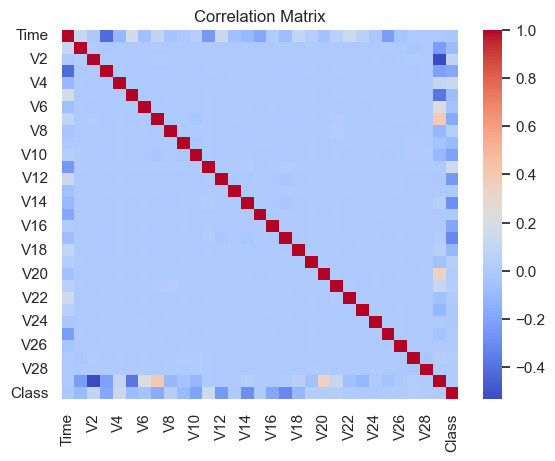

In [9]:
sns.heatmap(df.corr(), cbar=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Параметры V1-V28 имеют какую-то линейную зависимость с Time и Amount

В целом все признаки хорошо коррелируют с признком Class, кроме Time и Amount (т.е. они коррелируют с V1-V28, но линейной связи с Class нет)

Таким образом, можно видвинуть гипотезу, что если Time и Amount исключить или как-то преобразовать, то может быть результаты станут лучше

* Я пробовал исключать данные признаки из данных, но к улучшению результата это не привело
* И пробовал логарифмировать признак Amount, чтобы сделать разброс значений меньше, но к улучшением это также не привело

Поэтому в дальнейших расчётах Time и Amount остались без изменений

Построим `pairplot` для части параметров, выбираем случайные 4-ре параметра

Судя по изображениям, данные разделены нелинейно, но тем не менее, разделить их можно

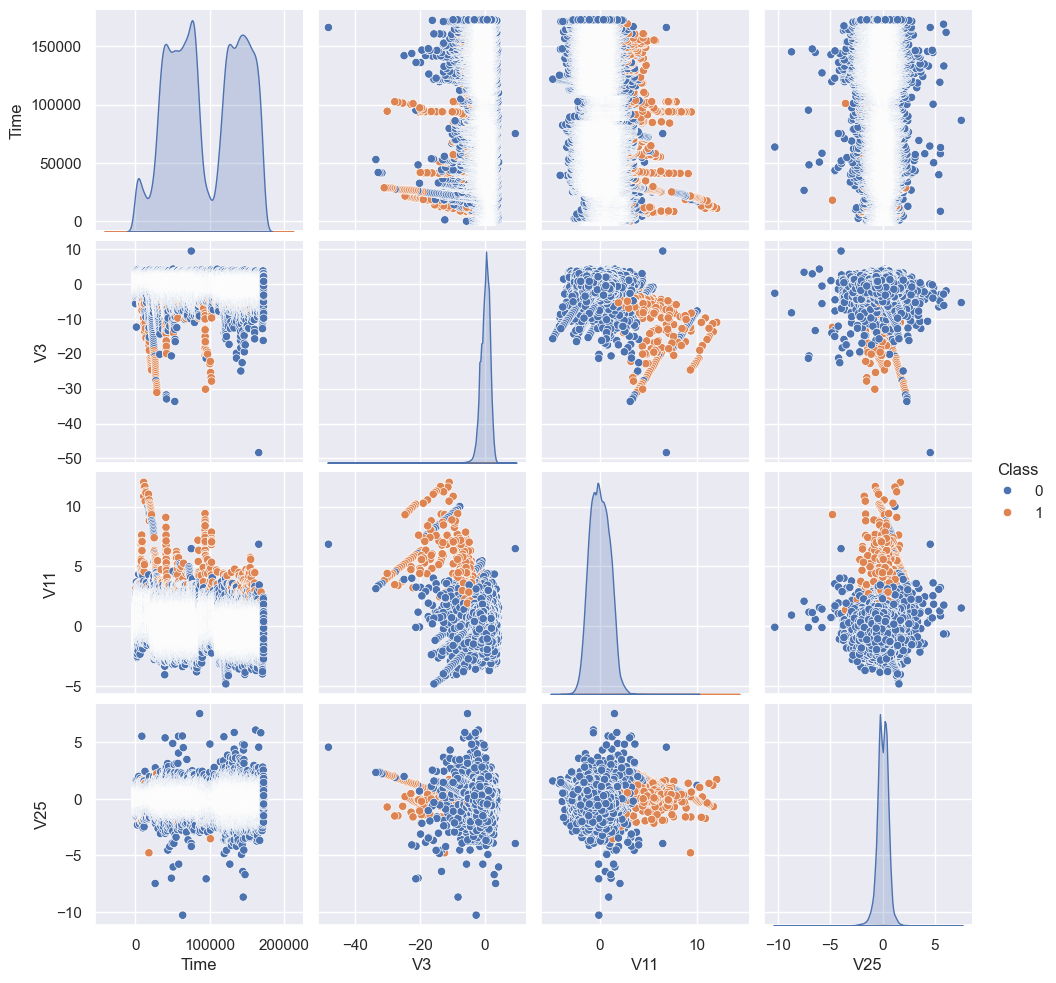

In [10]:
selected_features = ['Time', 'V3', 'V11', 'V25']
data_subset = df[selected_features + ['Class']]
sns.pairplot(data_subset, hue='Class', diag_kind='kde')
plt.show()

# LogisticRegression

    Логистическая регрессия является одним из базовых алгоритмов машинного обучения и может быть эффективной для классификации несбалансированных данных, поэтому вначале и воспользуемся ею

In [11]:
X = df.drop(['Class'], axis = 1)
y = df.Class

    Разделим данные на обучающую и тестовую части

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [13]:
percent_train = round(y_train.value_counts()[1] / y_train.shape[0] * 100, 3)
percent_test = round(y_test.value_counts()[1] / y_test.shape[0] * 100, 3)
print(f'Процент мошеннических операций: {percent_train}')
print(f'Процент мошеннических операций: {percent_test}')

Процент мошеннических операций: 0.167
Процент мошеннических операций: 0.167


    Сравним статистики тренировочной и тестовой выборки

In [14]:
X_train.describe() - X_test.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,...,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000,113490.000000
mean,349.321162,-0.002689,-0.000255,0.002039,0.010443,0.010629,0.002622,-0.000741,0.002758,-0.006590,...,0.001912,0.003912,-0.000073,-0.001938,0.001932,-0.001253,0.000507,-0.000846,0.003402,-0.503359
std,15.555743,-0.002333,-0.001586,-0.008102,0.017189,-0.064794,-0.023878,-0.094303,-0.016544,-0.002261,...,-0.049513,0.009040,0.000473,-0.012400,-0.002718,-0.001623,-0.003465,-0.015500,0.005570,-25.075175
min,-1.000000,-18.849443,-9.371029,14.644605,-0.123054,81.651178,-4.231194,-10.317913,-22.528299,-2.591540,...,30.850830,-11.941035,1.433721,11.978740,0.011778,1.598770,-0.070221,-12.670435,3.719188,0.000000
25%,238.500000,0.000747,0.003226,0.007934,0.002752,0.004931,0.003387,0.000541,0.000074,-0.001479,...,0.000850,-0.000129,0.002692,-0.000655,0.001579,-0.002673,0.001735,0.000533,0.001122,0.210000
50%,352.000000,-0.011077,0.002021,-0.007644,0.001674,0.005545,-0.002510,0.001078,0.001109,-0.001981,...,0.000647,0.001309,-0.000184,-0.001124,0.000439,-0.001868,0.001958,-0.000102,0.000847,0.180000
75%,272.750000,-0.003153,0.006808,-0.000498,0.013695,0.005580,0.004482,0.006003,0.000725,-0.005851,...,0.000617,0.000876,0.001640,0.000833,0.001836,-0.000798,-0.002883,0.001037,0.001940,0.700000
max,6.000000,0.015723,4.639080,5.280842,0.159807,1.890204,-51.908557,-86.286317,-0.419436,5.202106,...,-1.303695,7.139053,2.230857,0.444867,-0.568207,1.448738,0.054100,-19.459797,17.981087,-6781.160000


    Нормализуем данные

In [15]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

    Создание и обучение модели логистической регрессии

In [16]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_train_normalized, y_train);

    Предсказание на тестовой выборке

In [17]:
y_pred = model.predict(X_test_normalized)

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     84976
           1       0.05      0.89      0.10       142

    accuracy                           0.97     85118
   macro avg       0.53      0.93      0.54     85118
weighted avg       1.00      0.97      0.99     85118



Метрика `recall` имеет достаточно большие значения, но вот у метрики `precision` для `Class` = 1 значение всего 0.05, что значит лишь 5% значений наша модель смогла отобрать из всех принадлежаших классу 1

Чтобы улучшить этот показатель попробуем воспользоваться моделью 'случайного леса', т.к. моя работа с данными для улучшения метрик у модели Логистической регрессии не привели к значимым результатам

# RandomForestClassifier

Случайный лес лучше справляется с поиском сложных зависимостей в данных, поэтому далее обучим модель на `RandomForestClassifier`

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
X = df.drop(['Class'], axis = 1)
y = df.Class

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify = y)

In [22]:
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.fit_transform(X_test)

    Для уменьшения времени обучения используем параметр 'n_jobs' = -1, который использует все ядра для расчёта

In [23]:
model = RandomForestClassifier(random_state=42, n_jobs=-1)
model.fit(X_train_normalized, y_train);

In [24]:
y_pred = model.predict(X_test_normalized)

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     84976
           1       0.96      0.77      0.86       142

    accuracy                           1.00     85118
   macro avg       0.98      0.89      0.93     85118
weighted avg       1.00      1.00      1.00     85118



Метрика recall снизилась с 0.89 до 0.77, но precision значительно больше увеличилась и теперь равняется 0.96

# Результат

По итогу данной работы были обучены две модели для обнаружение мошенничества с кредитными картами

Использовались следующие модели: `LogisticRegression` и `RandomForestClassifier`

Также были получены метрики результатов предсказаний моделей. Основные метрики для анализа предсказания: `precision` и `recall`
* У Logistic Regression метрики precision и recall имеют значения 0.05 и 0.89 соответственно
* У Random Forests метрики precision и recall имеют значения 0.96 и 0.77 соответственно

При использовании модели логистической регрессии мы будем реже классифицировать обычные транзакции как мошеннические, но при этом количество выявленных мошеннических транзакций будет очень мало по сравнению со всеми подобными операциями

Поэтому, на мой взгляд, модель случайных деревьев показала себя лучше в данном случае. Хотя она чаще делала ложноположительные выборы (`false positive`), она при этом сделала гораздо больше верноположительных выборов (`true positive`), что, на мой взгляд, является более важным